In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from sklearn.calibration import calibration_curve
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from fart.common.constants import (
    CLOSE,
    EMA_FAST,
    HONOLULU_BLUE,
    MOVEMENT,
    STATIONARY,
    TIMESTAMP,
)
from fart.features.calculate_technical_indicators import calculate_technical_indicators
from fart.features.parse_timestamp_to_datetime import parse_timestamp_to_datetime

In [2]:
df = pl.read_csv("../data/BTC-EUR.csv")

# Calculate technical indicators and add them to DataFrame
df = calculate_technical_indicators(df)

In [3]:
df = df.with_columns((pl.col(CLOSE) - pl.col(EMA_FAST)).alias(STATIONARY))
df = df.with_columns(
    pl.when(pl.col(STATIONARY) < pl.col(STATIONARY).shift(-1))
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias(MOVEMENT)
)

In [4]:
df = df.drop_nans()
df.tail(10)

Timestamp,Open,High,Low,Close,Volume,Bollinger Bands: Upper,Bollinger Bands: Middle,Bollinger Bands: Lower,Exponential Moving Average: Fast,Exponential Moving Average: Slow,Moving Average Convergence Divergence,Moving Average Convergence Divergence: Signal,Moving Average Convergence Divergence: Histogram,Relative Strength Index,Stationary,Movement
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
1740369600000,90826.0,90960.0,90699.0,90699.0,3.111451,92030.667891,91400.45,90770.232109,91103.727422,91330.781326,-206.311001,-126.572916,-79.738085,29.179132,-404.727422,1
1740371400000,90705.0,90844.0,90508.0,90700.0,6.796767,92057.143704,91359.85,90662.556296,91022.981938,91273.437569,-229.658033,-147.189939,-82.468094,29.221076,-322.981938,1
1740373200000,90707.0,90968.0,90645.0,90901.0,6.077391,92040.122193,91324.8,90609.477807,90998.58555,91239.579608,-229.298494,-163.61165,-65.686844,37.263837,-97.58555,1
1740375000000,90896.0,91113.0,90884.0,91080.0,8.139245,92019.484786,91302.65,90585.815214,91014.86844,91225.072371,-212.124513,-173.314223,-38.810291,43.4289,65.13156,0
1740376800000,91099.0,91150.0,91025.0,91078.0,5.86278,91999.735885,91282.0,90564.264115,91027.494752,91211.702156,-196.411286,-177.933635,-18.477651,43.377608,50.505248,1
1740378600000,91165.0,91372.0,91077.0,91278.0,6.794616,91977.447755,91269.15,90560.852245,91077.595802,91217.729232,-165.907632,-175.528435,9.620803,49.766769,200.404198,0
1740380400000,91278.0,91330.0,91119.0,91245.0,6.10078,91965.627719,91260.55,90555.472281,91111.076641,91220.208393,-142.750551,-168.972858,26.222307,48.788536,133.923359,1
1740382200000,91245.0,91480.0,91202.0,91455.0,20.092714,91962.336705,91259.05,90555.763295,91179.861313,91241.553085,-106.228615,-156.424009,50.195394,54.868147,275.138687,0
1740384000000,91479.0,91532.0,91125.0,91151.0,13.725847,91948.091192,91246.5,90544.908808,91174.08905,91233.320986,-100.654693,-145.270146,44.615453,46.299307,-23.08905,1


In [5]:
df = df.to_pandas()
X = df.drop(columns=[TIMESTAMP, MOVEMENT])
y = df[MOVEMENT]

In [6]:
random_state = 42  # Set random state for reproducibility

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_state,
    shuffle=False,  # Do not shuffle the data as is time series data
    test_size=0.2,
)

In [ ]:
preprocessor = make_pipeline(
    StandardScaler()
)

In [9]:
classifiers = [
    ["AdaBoost", AdaBoostClassifier(algorithm="SAMME", random_state=random_state)],
    ["Gradient Boosting", GradientBoostingClassifier(random_state=random_state)],
    ["Logistic Regression", LogisticRegression()],
    ["Nearest Neighbors", KNeighborsClassifier()],
    ["Neural Net", MLPClassifier(alpha=1, max_iter=1000, random_state=random_state)],
    ["Random Forest", RandomForestClassifier(random_state=random_state)],
]

In [10]:
y_predictions = []
y_probabilities = []

for model_name, classifier in classifiers:
    print(f"Training: {model_name}")
    classifier = make_pipeline(preprocessor, classifier)
    classifier.fit(X_train, y_train)

    y_predictions.append([model_name, classifier.predict(X_test)])
    y_probabilities.append([model_name, classifier.predict_proba(X_test)[:, 1]])

print("\n✅ Training complete!")

Training: AdaBoost
Training: Gradient Boosting
Training: Logistic Regression
Training: Nearest Neighbors
Training: Neural Net
Training: Random Forest

✅ Training complete!


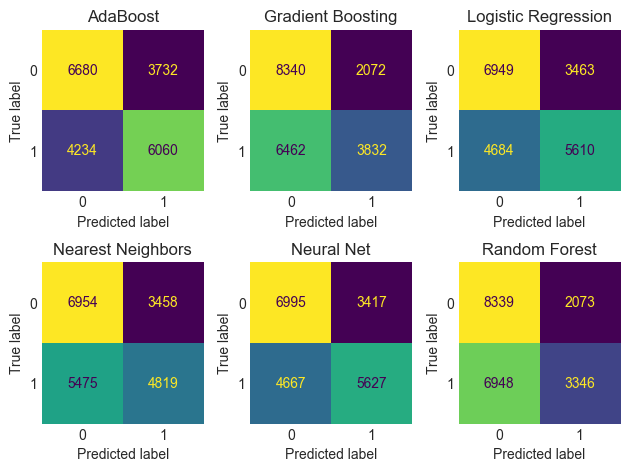

In [ ]:
plt.style.use("seaborn-v0_8-dark")

_, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (model_name, y_prediction) in zip(axes.flatten(), y_predictions):
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_prediction,
        ax=ax,
        colorbar=False,
    )
    ax.set_title(model_name)

plt.tight_layout()
plt.show()

In [12]:
for model_name, y_prediction in y_predictions:
    print(f"{model_name}\n")
    print(classification_report(y_test, y_prediction, zero_division=1))
    print("\n")

AdaBoost

              precision    recall  f1-score   support

           0       0.61      0.64      0.63     10412
           1       0.62      0.59      0.60     10294

    accuracy                           0.62     20706
   macro avg       0.62      0.62      0.61     20706
weighted avg       0.62      0.62      0.62     20706



Gradient Boosting

              precision    recall  f1-score   support

           0       0.56      0.80      0.66     10412
           1       0.65      0.37      0.47     10294

    accuracy                           0.59     20706
   macro avg       0.61      0.59      0.57     20706
weighted avg       0.61      0.59      0.57     20706



Logistic Regression

              precision    recall  f1-score   support

           0       0.60      0.67      0.63     10412
           1       0.62      0.54      0.58     10294

    accuracy                           0.61     20706
   macro avg       0.61      0.61      0.60     20706
weighted avg       0

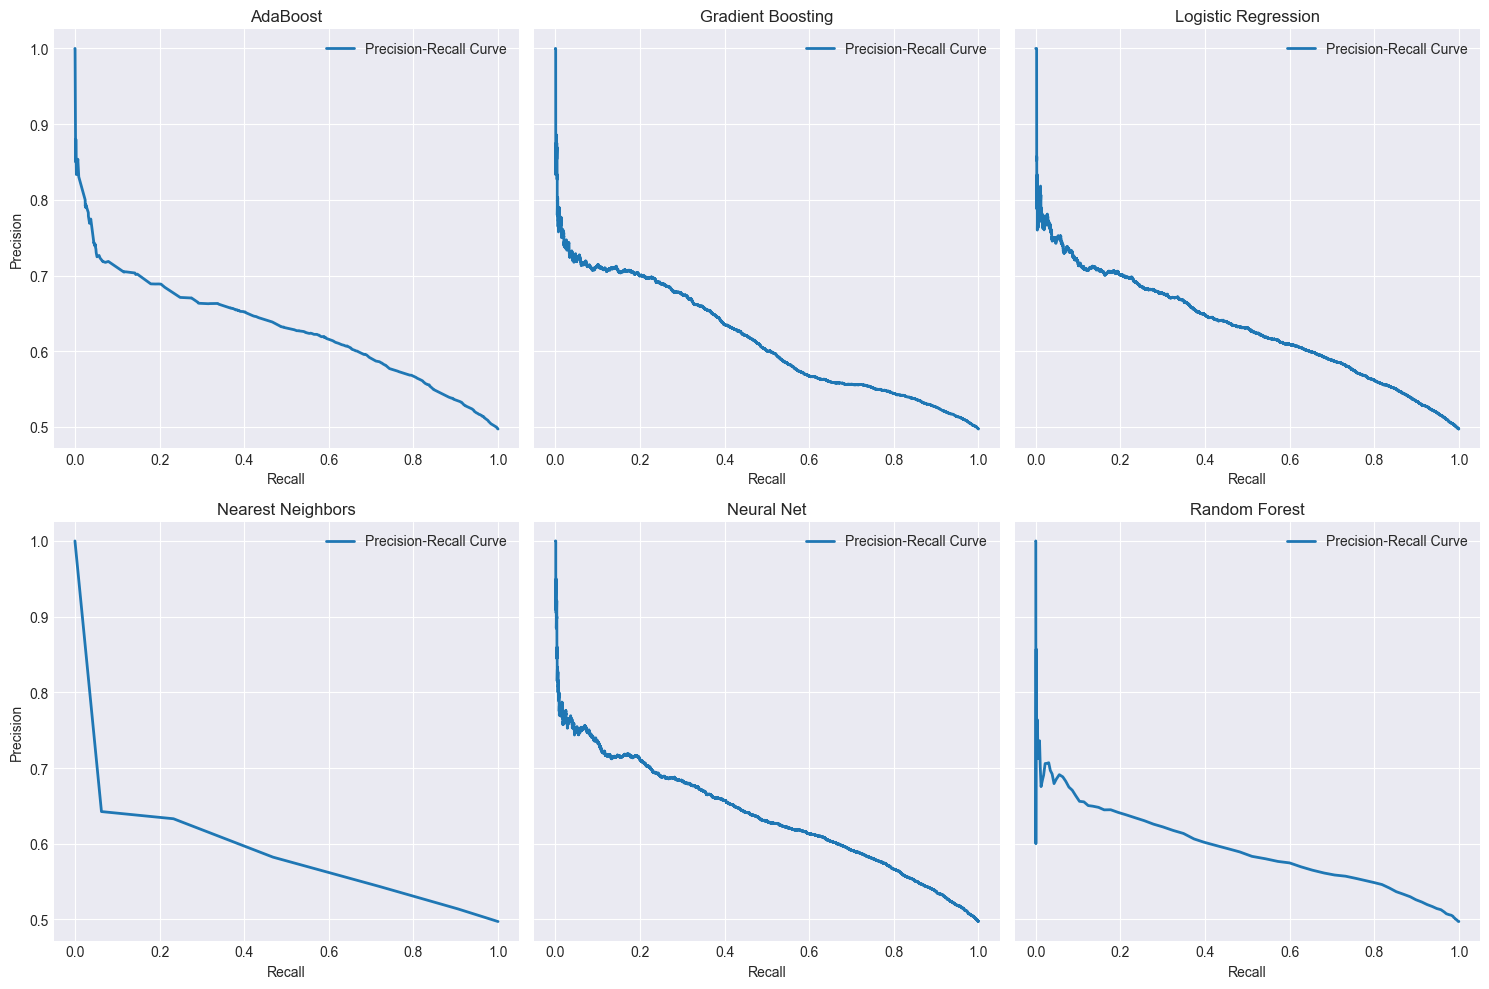

In [13]:
plt.style.use("seaborn-v0_8-darkgrid")

_, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

for ax, (model_name, probabilities) in zip(axes.flatten(), y_probabilities):
    precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)

    ax.plot(recalls, precisions, label="Precision-Recall Curve", linewidth=2, color=HONOLULU_BLUE)
    ax.set_xlabel("Recall")
    ax.set_title(model_name)
    ax.legend()

axes[0][0].set_ylabel("Precision")
axes[1][0].set_ylabel("Precision")

plt.tight_layout()
plt.show()

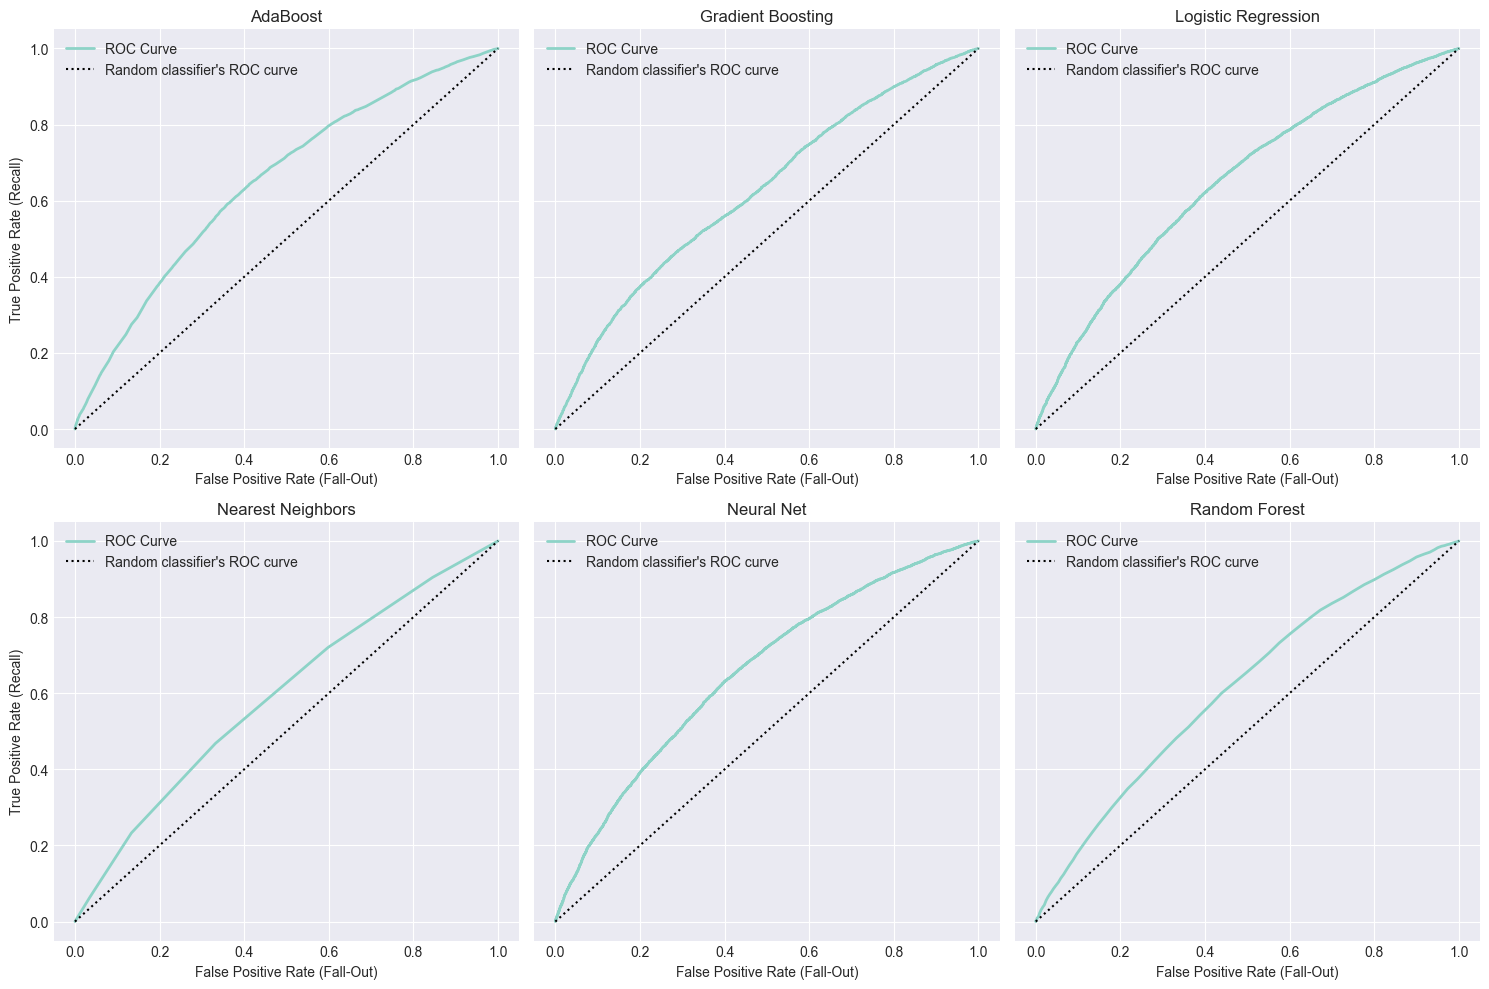

In [14]:
plt.style.use("seaborn-v0_8-darkgrid")

_, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

for ax, (model_name, y_probability) in zip(axes.flatten(), y_probabilities):
    false_positive_rates, true_positive_rates, thresholds = roc_curve(y_test, y_probability)

    ax.plot(false_positive_rates, true_positive_rates, label="ROC Curve", linewidth=2)
    ax.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
    ax.set_xlabel("False Positive Rate (Fall-Out)")
    
    ax.set_title(model_name)
    ax.legend()

axes[0][0].set_ylabel("True Positive Rate (Recall)")
axes[1][0].set_ylabel("True Positive Rate (Recall)")

plt.tight_layout()
plt.show()

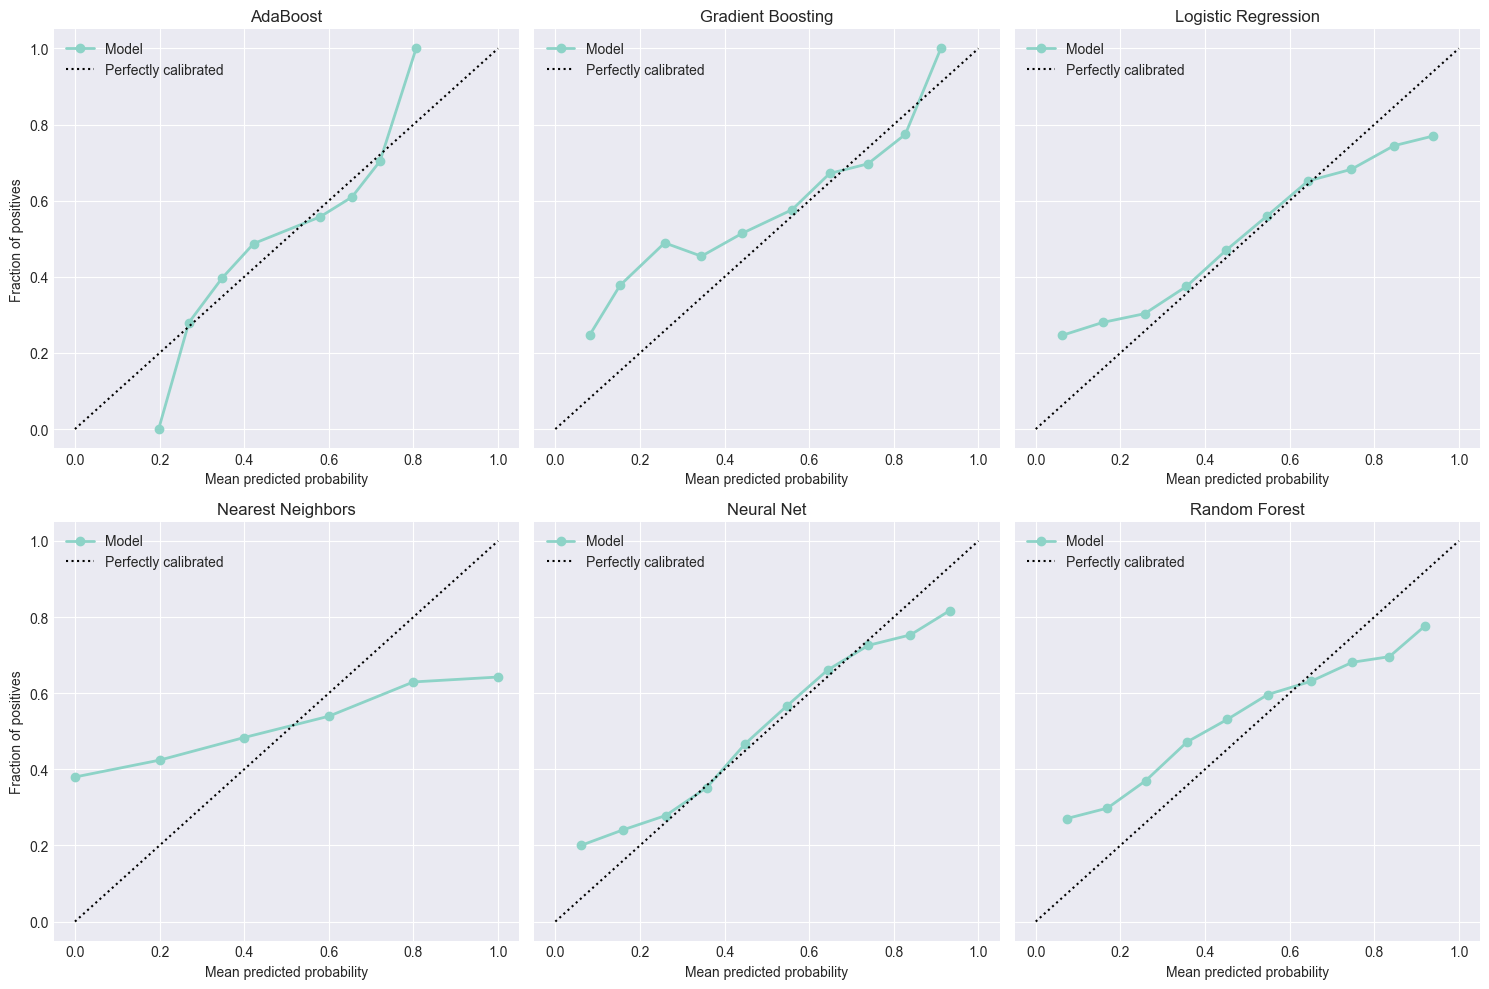

In [15]:
plt.style.use("seaborn-v0_8-darkgrid")

_, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

for ax, (model_name, y_probability) in zip(axes.flatten(), y_probabilities):
    prob_true, prob_pred = calibration_curve(y_test, y_probability, n_bins=10)

    ax.plot(prob_pred, prob_true, marker="o", label="Model", linewidth=2)
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax.set_xlabel("Mean predicted probability")
    ax.set_title(model_name)
    ax.legend()

axes[0][0].set_ylabel("Fraction of positives")
axes[1][0].set_ylabel("Fraction of positives")

plt.tight_layout()
plt.show()

In [16]:
# param_distributions = {
#     'randomforestclassifier__bootstrap': [True, False],
#     'randomforestclassifier__max_depth': randint(1, 30),
#     'randomforestclassifier__max_features': ['sqrt', 'log2'],
#     'randomforestclassifier__min_samples_leaf': randint(1, 20),
#     'randomforestclassifier__min_samples_split': randint(1, 20),
#     'randomforestclassifier__n_estimators': randint(10, 1000),
# }
# random_search = RandomizedSearchCV(
#     make_pipeline(
#         preprocessor,
#         RandomForestClassifier(bootstrap=False, random_state=random_state),
#     ),
#     cv=5,
#     n_iter=2,
#     param_distributions=param_distributions,
#     scoring="accuracy",
# )
# random_search.fit(X_train, y_train)

# print(random_search.best_params_)
# print(random_search.best_score_)